In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.sparse import diags

In [2]:
def alpha(n):
    return 0.5 * (n**2 * s**2 - n * (r-D)) * dt

def beta(n):
    return 1 - (r + n**2 * s**2) * dt

def gamma(n):
    return 0.5 * (n**2 * s**2 + n * (r-D)) * dt

def Stability(sgridsize,dt):
    if dt <= 1/(s**2 * sgridsize**2):
#         print('Stable')
        return 0
    else:
        print('Unstable: Decrease dt')
        return 1



def Explicit(EuroAmerican,CallPut,Plot = False,Grid = False):
    
    stable = Stability(sgridsize,dt)
    end = 0
    grid = np.zeros((tgridsize,sgridsize))
    
    leftdiff = abs(ds*np.asarray(range(sgridsize))[int(index)] - S0)
    rightdiff = abs(ds*np.asarray(range(sgridsize))[int(index+1)] - S0)
    
    leftweight = rightdiff/(leftdiff+rightdiff)
    rightweight = leftdiff/(leftdiff+rightdiff)

    if EuroAmerican == 'European':
        
        flag = 0

    elif EuroAmerican == 'American':
        
        flag = 1
    
    else:
        
        print('Enter European or American')
        end = 1
    
    if CallPut == 'Call':

        # Payoff at expiry
        for i in range(sgridsize):
            grid[-1,i] = max(i*ds-E,0)

        # Option value when S is 0
        for i in range(tgridsize):
            grid[i,0] = 0

        # Option Value at Smax is (Smax-E)-ds
        for i in range(tgridsize):
            grid[i,-1] = (smax - E)-ds



    elif CallPut == 'Put':
        # Payoff at expiry
        for i in range(sgridsize):
            grid[-1,i] = max(E-i*ds,0)

        # Option value when S is 0
        for i in range(tgridsize):
            grid[i,0] = (E*np.exp(-r*i*dt) - smax)-ds

        # Option Value at Smax
        for i in range(tgridsize):
            grid[i,-1] = 0 
        
    else:
        print('Enter Call or Put')
        end = 1

    if end == 0 and stable == 0:
        # for grid[m,n]; x is time and y is price
        
        for m in range(len(grid)-2,-1,-1):
            # backwards starting from the 2nd last 2, as last t is inital conditions

            for n in range(1,len(grid[0])-1):
                # increasing, exlcuding n = 0, n = 99 as are initial conditions

                grid[m,n] = alpha(n) * grid[m+1,n-1] + beta(n) * grid[m+1,n] + gamma(n) * grid[m+1,n+1]
                
            # Boundary coniditions
#             grid[m,0] = (1-r * dt) * grid[m+1,0]
#             grid[m,-1] = (alpha(sgridsize) - gamma(sgridsize))*grid[m+1,-2] + (beta(sgridsize) - 2 * gamma(sgridsize))*grid[m+1,-1]
              
            if flag == 1:
                # if American
                
                for n,val in enumerate(grid[m]):
                    # loop through grid at time m
                    
                    if val < grid[-1,n]:
                        # if value < payoff, swap for payoff
                        
                        grid[m,n] = grid[-1,n]
                        
                    else:
                        
                        pass
                    
            else:
                
                pass

        if Plot == True:    
            
            return grid[0]
        
        if Grid == True:
                
            return grid
        
        else:

            return leftweight*grid[0,int(index)] + rightweight*grid[0,int(index)+1]

    
    else:
        
        return 0
    


In [10]:
def FastExplicit(EuroAmerican,CallPut,Plot = False,Grid = False):
    # Vectorised function that is much faster
    stable = Stability(sgridsize,dt)
    end = 0
    grid = np.zeros((tgridsize,sgridsize))
    
    leftdiff = abs(ds*np.asarray(range(sgridsize))[int(index)] - S0)
    rightdiff = abs(ds*np.asarray(range(sgridsize))[int(index+1)] - S0)
    
    leftweight = rightdiff/(leftdiff+rightdiff)
    rightweight = leftdiff/(leftdiff+rightdiff)

    if EuroAmerican == 'European':
        
        flag = 0

    elif EuroAmerican == 'American':
        
        flag = 1
    
    else:
        
        print('Enter European or American')
        end = 1
    
    if CallPut == 'Call':

        # Payoff at expiry
        for i in range(sgridsize):
            grid[-1,i] = max(i*ds-E,0)

        # Option value when S is 0
        for i in range(tgridsize):
            grid[i,0] = 0

        # Option Value at Smax is (Smax-E)-ds
        for i in range(tgridsize):
            grid[i,-1] = (smax - ds) - E



    elif CallPut == 'Put':
        
        # Payoff at expiry
        for i in range(sgridsize):
            grid[-1,i] = max(E-i*ds,0)

        # Option value when S is 0
        for i in range(tgridsize):
            grid[i,0] = E

        # Option Value at Smax
        for i in range(tgridsize):
            grid[i,-1] = 0 
        
    else:
        print('Enter Call or Put')
        end = 1

    if end == 0 and stable == 0:
        # for grid[m,n]; x is time and y is price
        
        # array for inputs of alpha, beta and gamma
        vals = np.arange(1,len(grid[0])-1,1)
        
        # backwards starting from the 2nd last 2, as last t is inital conditions
        for m in range(len(grid)-2,-1,-1):
            
            grid[m,1:-1] = alpha(vals) * grid[m+1,:-2] + beta(vals) * grid[m+1,1:-1] + gamma(vals) * grid[m+1,2:]
            
            # if American
            if flag == 1:
                
                mask = grid[m, :] < grid[-1, :]

                # Use the boolean mask to update values in grid
                grid[m, :][mask] = grid[-1, :][mask]

        if Plot == True:    
            
            return grid[0]
        
        if Grid == True:
                
            return grid
        
        else:

            return leftweight*grid[0,int(index)] + rightweight*grid[0,int(index)+1]

    
    else:
        
        return 0
    
def Delta(grid):
    
    return (grid[0,int(index)+1]-grid[0,int(index)-1])/(2*ds)

def Gamma(grid):
    
    return (grid[0,int(index)+1]-2*grid[0,int(index)]+grid[0,int(index)-1])/ds**2

def Vega(first,last):
    
    return (first - last)/0.1

def Theta(grid):
    
    return (grid[0,int(index)]-grid[1,int(index)])/dt

In [12]:
# Initialise Values
tgridsize = 100000
sgridsize = 1000
T = 1
E = 110
smax = E*3
s = 0.2
S0 = 100
r = 0.05
D = 0.00
Type = 'American'
Direction = 'Call'

ds = smax/sgridsize
dt = T/tgridsize

index = S0/ds

Call = FastExplicit(Type,'Call')
Put = FastExplicit(Type,'Put')
print(f'Call in Explicit Scheme: {Call:.3f}')
print(f'Put in Explicit Scheme: {Put:.3f}')

grid = FastExplicit(Type,Direction,Grid=True)
print('\nGreeks:')
print(f'Delta: {Delta(grid):.3f}')
print(f'Gamma: {Gamma(grid):.3f}')

s = float(s+0.05)
first = FastExplicit(Type,Direction)
s = float(s-0.1)
last = FastExplicit(Type,Direction)

print(f'Vega: {Vega(first,last):.3f}')
print(f'Theta: {Theta(grid):.3f}')

Call in Explicit Scheme: 6.040
Put in Explicit Scheme: 11.973

Greeks:
Delta: 0.449
Gamma: 0.020
Vega: 39.505
Theta: 5.902


In [64]:
grid = FastExplicit('European','Call',Grid=True)

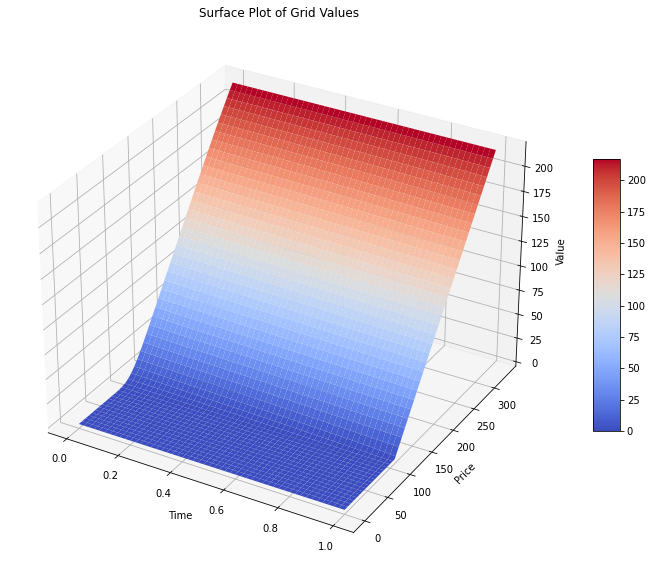

In [49]:
grid = np.array(grid)
time_values = np.linspace(0, 1, tgridsize)
price_values = np.linspace(0, smax, sgridsize)
time_mesh, price_mesh = np.meshgrid(time_values, price_values)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(time_mesh, price_mesh, grid.T, cmap=cm.coolwarm)  # Transpose grid
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_zlabel('Value')
ax.set_title('Surface Plot of Grid Values')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
# ax.view_init(30,120)
plt.show()

In [50]:
def a(n):
    return -0.5 * (s**2 * n**2 - n * (r-D)) * dt

def b(n):
    return 1 + (s**2 * n**2  + r) * dt

def c(n):
    return -0.5 * (s**2 * n**2 + n * (r-D)) * dt

def a_hat(n):
    return n * (r-D) * dt

def b_hat(n):
    return 1 - (n * (r - D) - r) * dt

    
def Implicit(EuroAmerican,CallPut,Plot = False, Grid = False):

    # Intialise Grid
    grid = np.zeros((tgridsize,sgridsize))
    
    # weights for interpolation
    leftdiff = abs(ds*np.asarray(range(sgridsize))[int(index)] - S0)
    rightdiff = abs(ds*np.asarray(range(sgridsize))[int(index+1)] - S0)
    leftweight = rightdiff/(leftdiff+rightdiff)
    rightweight = leftdiff/(leftdiff+rightdiff)
    
    if EuroAmerican == 'European':
        flag = 0
        end = 0

    elif EuroAmerican == 'American':
        flag = 1
        end = 0
        
    else:
        print('Choose European or American')
        end = 1
        
        
    if CallPut == 'Call':

        # Payoff at expiry
        for i in range(sgridsize):
            grid[-1,i] = max(i*ds-E,0)

        # Option value when S is 0
        for i in range(tgridsize):
            grid[i,0] = 0

        # Option Value at Smax is (Smax-E)
        for i in range(tgridsize):
            grid[i,-1] = smax - E - ds
    
    elif CallPut == 'Put':
        
        # Payoff at expiry
        for i in range(sgridsize):
            grid[-1,i] = max(E-i*ds,0)

        # Option value when S is E
        for i in range(tgridsize):
            grid[i,0] = E - ds

        # Option Value at Smax is 0
        for i in range(tgridsize):
            grid[i,-1] = 0   
    
    else:
        
        print('Choose Call or Put')
        end = 1

    if end == 0:

        for m in range(len(grid)-2,-1,-1):
            # m at each time step

            # main diagonal
            main_diag = [b(n) for n in range(sgridsize)]
            
             # upper diagonal
            upper_diag = [c(n) for n in range(sgridsize-1)]
            
            # lower diagonal
            lower_diag = [a(n) for n in range(1,sgridsize)]
            
            # Tridiagonal Matrix
            A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], shape=(sgridsize, sgridsize), format='csr')

            # Boundary conditions for Matrix
            
            A[sgridsize-1,sgridsize-2] = a_hat(sgridsize) # swap -2 -1
            A[sgridsize-1,sgridsize-1] = b_hat(sgridsize)

            # Solve system
            grid[m] = sp.sparse.linalg.spsolve(sp.sparse.csc_matrix(A), grid[m+1])
            
            # Boundary condition
            grid[m,0] = (1 + r * dt)*grid[m-1,0]

            if flag == 1:
                # American Option
                
                for n,val in enumerate(grid[m]):
                    # loop through grid at time m
                    
                    if val < grid[-1,n]:
                        # if value < payoff, swap for payoff

                        grid[m,n] = grid[-1,n]
                        
                else:
                        
                    pass
            
            else:
                
                pass
                
        if Plot == True:
            
            return grid[0]
        
        elif Grid == True:
            
            return grid
        
        else:
            
            # Interpolate
            return leftweight*grid[0,int(index)] + rightweight*grid[0,int(index)+1]

    
    
    else:
        
        return 0


In [51]:
# Initialise Values
tgridsize = 1000
sgridsize = 400
T = 1
E = 110
smax = E*3
s = 0.2
S0 = 100
r = 0.05
D = 0.00

ds = smax/sgridsize
dt = T/tgridsize

index =S0/ds

Call = Implicit('European','Call')
Put = Implicit('European','Put')
print(f'Call in Implicit Scheme: {Call:.3f}')
print(f'Put in Implicit Scheme: {Put:.3f}')

Call in Implicit Scheme: 6.035
Put in Implicit Scheme: 10.675


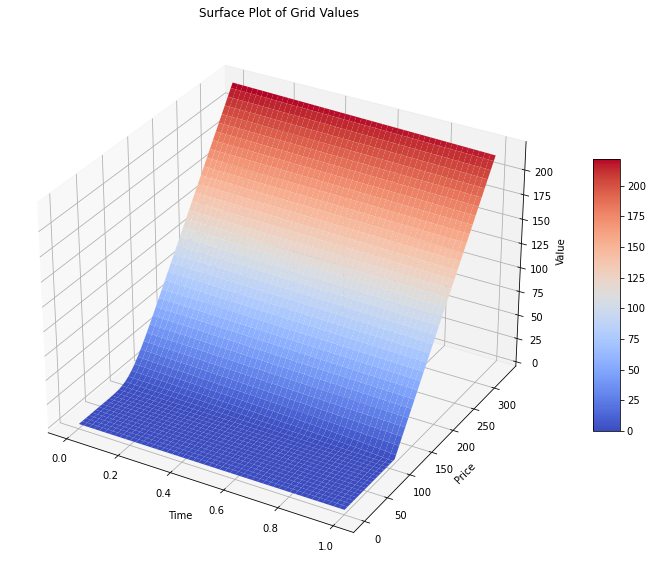

In [52]:
grid = Implicit('American','Call',Grid=True)

grid = np.array(grid)
time_values = np.linspace(0, 1, tgridsize)
price_values = np.linspace(0, smax, sgridsize-1)
time_mesh, price_mesh = np.meshgrid(time_values, price_values[1:])


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(time_mesh, price_mesh, grid[:,1:-1].T, cmap=cm.coolwarm)  # Transpose grid 
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_zlabel('Value')
ax.set_title('Surface Plot of Grid Values')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

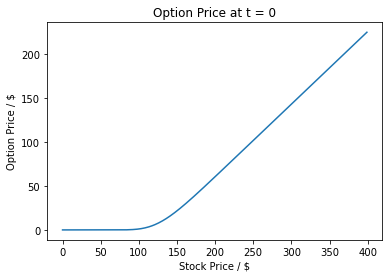

In [53]:
fig, ax = plt.subplots()
ax.plot(grid[0])
ax.set_xlabel('Stock Price / $')
ax.set_ylabel('Option Price / $')
ax.set_title('Option Price at t = 0')
plt.show()